In [20]:
import pystac_client
import planetary_computer
import odc.stac
import matplotlib.pyplot as plt

from pystac.extensions.eo import EOExtension as eo

In [21]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [22]:
# lat, lon = 38.904722, -77.016389 # Washington, DC
lat, lon = 35.978611, -78.9 # Durham, NC
# lat, lon = 40.712778, -74.006111 # New York, NY
# lat, lon = 41.711469, -71.191548 # Somerset, MA
delta = 0.1

bbox_of_interest = [lon - delta, lat - delta, lon + delta, lat + delta]

# time_of_interest = "2021-05-01/2024-08-28"
time_of_interest = "2024-05-01/2024-08-28" # Summer months
# time_of_interest = "2024-01-01/2024-03-28" # Winter months

In [23]:
search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox_of_interest,
    datetime=time_of_interest,
    query={
        "eo:cloud_cover": {"lt": 10},
        "platform": {"in": ["landsat-8", "landsat-9"]},
    },
)

items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 9 Items


In [24]:
selected_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {selected_item.id} from {selected_item.datetime.date()}"
    + f" with {selected_item.properties['eo:cloud_cover']}% cloud cover"
)

Choosing LC08_L2SP_016035_20240715_02_T1 from 2024-07-15 with 0.22% cloud cover


In [25]:
max_key_length = len(max(selected_item.assets, key=len))
for key, asset in selected_item.assets.items():
    print(f"{key.rjust(max_key_length)}: {asset.title}")

              qa: Surface Temperature Quality Assessment Band
             ang: Angle Coefficients File
             red: Red Band
            blue: Blue Band
            drad: Downwelled Radiance Band
            emis: Emissivity Band
            emsd: Emissivity Standard Deviation Band
            trad: Thermal Radiance Band
            urad: Upwelled Radiance Band
           atran: Atmospheric Transmittance Band
           cdist: Cloud Distance Band
           green: Green Band
           nir08: Near Infrared Band 0.8
          lwir11: Surface Temperature Band
          swir16: Short-wave Infrared Band 1.6
          swir22: Short-wave Infrared Band 2.2
         coastal: Coastal/Aerosol Band
         mtl.txt: Product Metadata File (txt)
         mtl.xml: Product Metadata File (xml)
        mtl.json: Product Metadata File (json)
        qa_pixel: Pixel Quality Assessment Band
       qa_radsat: Radiometric Saturation and Terrain Occlusion Quality Assessment Band
      qa_aerosol: Aeros

In [26]:
bands_of_interest = ["nir08", "red", "green", "blue", "lwir11"]
data = odc.stac.stac_load(
    [selected_item], bands=bands_of_interest, bbox=bbox_of_interest
).isel(time=0)
data

<xarray.Dataset> Size: 5MB
Dimensions:      (y: 754, x: 618)
Coordinates:
  * y            (y) float64 6kB 3.995e+06 3.995e+06 ... 3.972e+06 3.972e+06
  * x            (x) float64 5kB 6.801e+05 6.801e+05 ... 6.986e+05 6.986e+05
    spatial_ref  int32 4B 32617
    time         datetime64[ns] 8B 2024-07-15T15:52:55.004488
Data variables:
    nir08        (y, x) uint16 932kB 16132 17583 17404 ... 19733 19296 19255
    red          (y, x) uint16 932kB 8990 8315 8434 8144 ... 14056 9513 9042
    green        (y, x) uint16 932kB 9288 8844 8949 8753 ... 13356 10071 9560
    blue         (y, x) uint16 932kB 8479 8004 8128 7927 ... 11907 8593 8599
    lwir11       (y, x) uint16 932kB 46537 46539 46562 ... 49276 49363 49488

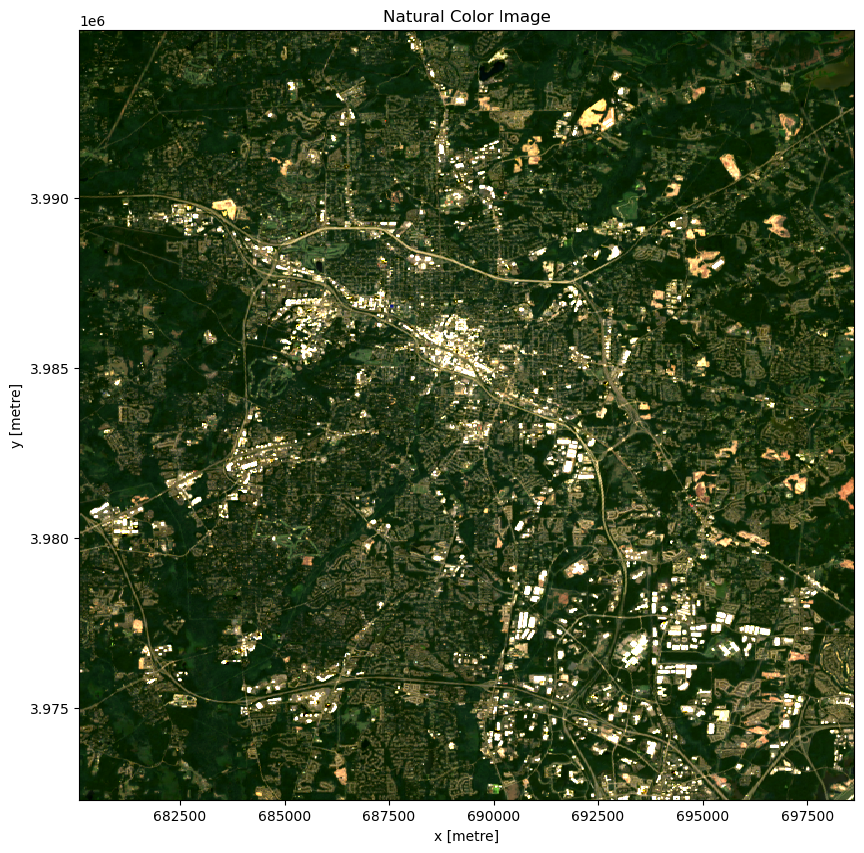

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))

data[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax)
ax.set_title("Natural Color Image");

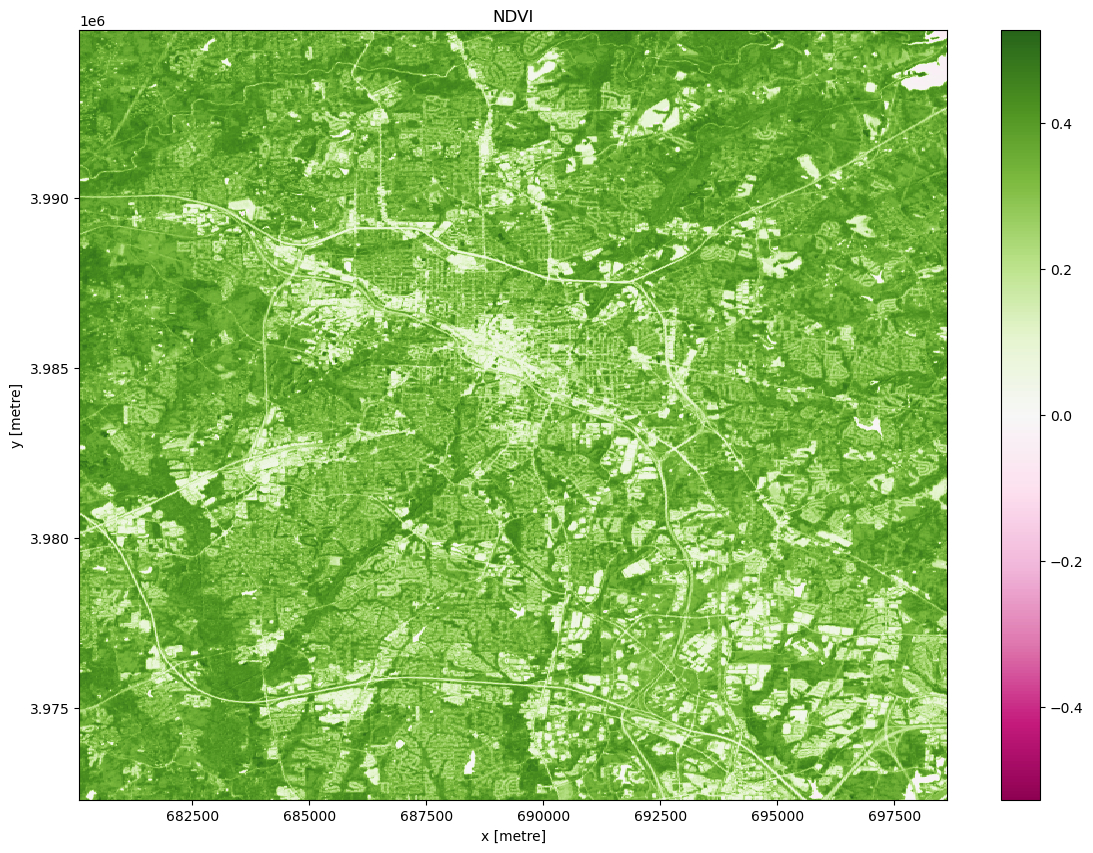

In [28]:
red = data["red"].astype("float")
nir = data["nir08"].astype("float")
ndvi = (nir - red) / (nir + red)

fig, ax = plt.subplots(figsize=(14, 10))
ndvi.plot.imshow(ax=ax, cmap="PiYG")
ax.set_title("NDVI");


In [29]:
band_info = selected_item.assets["lwir11"].extra_fields["raster:bands"][0]
band_info

{'unit': 'kelvin',
 'scale': 0.00341802,
 'nodata': 0,
 'offset': 149.0,
 'data_type': 'uint16',
 'spatial_resolution': 30}

In [30]:
temperature = data["lwir11"].astype(float)

# Replace missing values with median
# temperature.data[temperature.data == band_info["nodata"]] = data["lwir11"].median().values

# Convert to Kelvin
temperature *= band_info["scale"]
temperature += band_info["offset"]
temperature[:5, :5]

<xarray.DataArray 'lwir11' (y: 5, x: 5)> Size: 200B
array([[308.06439674, 308.07123278, 308.14984724, 308.0917409 ,
        308.13617516],
       [307.79437316, 307.88324168, 307.83880742, 307.85589752,
        307.9721102 ],
       [307.45598918, 307.65081632, 307.54827572, 307.4764973 ,
        307.5277676 ],
       [307.15520342, 307.24065392, 307.1517854 , 307.05266282,
        307.05266282],
       [306.8099834 , 306.84758162, 306.78263924, 306.73478696,
        306.73136894]])
Coordinates:
  * y            (y) float64 40B 3.995e+06 3.995e+06 ... 3.995e+06 3.995e+06
  * x            (x) float64 40B 6.801e+05 6.801e+05 ... 6.802e+05 6.802e+05
    spatial_ref  int32 4B 32617
    time         datetime64[ns] 8B 2024-07-15T15:52:55.004488
Attributes:
    nodata:   0

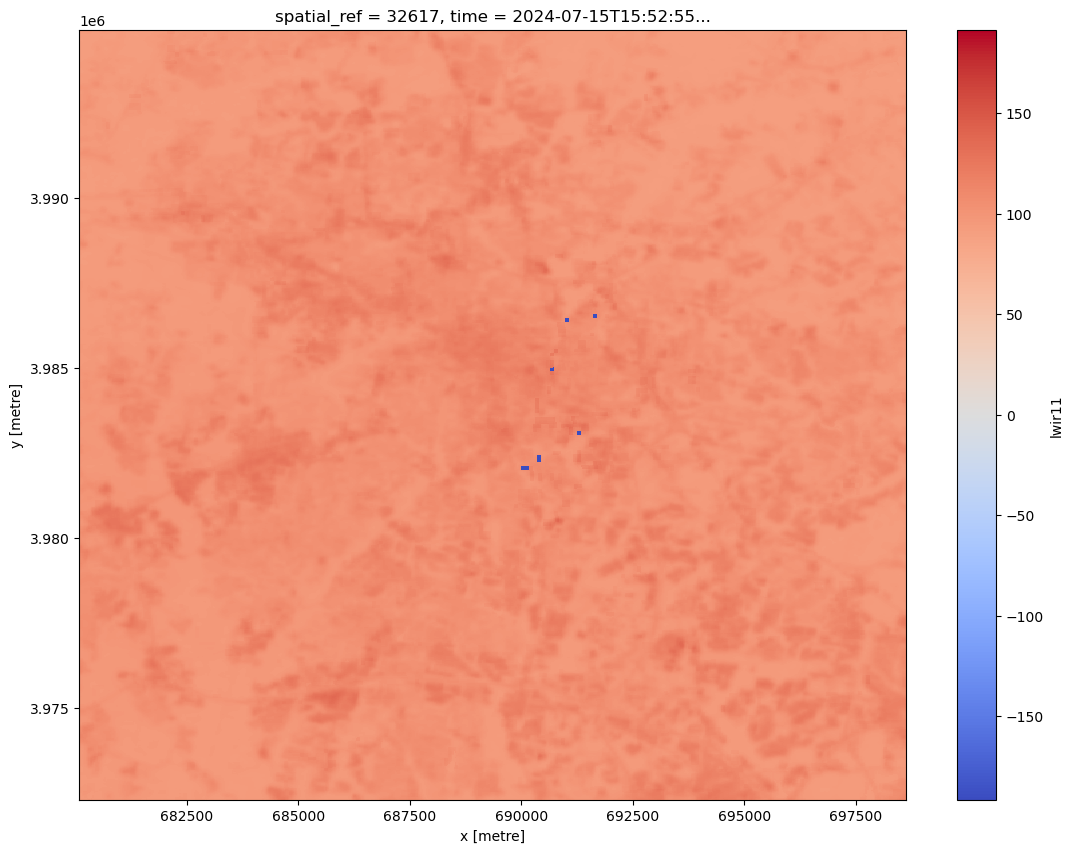

In [31]:
celsius = temperature - 273.15
fahrenheit = celsius * 9/5 + 32

discretize = False
if discretize:
    cmap = plt.cm.get_cmap("coolwarm", 15)
    fahrenheit.plot.imshow(cmap=cmap, size=10)
else:
    fahrenheit.plot.imshow(cmap = 'coolwarm', size=10)

In [32]:
fahrenheit.data

array([[ 94.84591413,  94.858219  ,  94.99972503, ...,  91.3205683 ,
         91.25289151,  91.18521471],
       [ 94.35987169,  94.51983502,  94.43985336, ...,  91.46822677,
         91.37594023,  91.3205683 ],
       [ 93.75078052,  94.10146938,  93.9168963 , ...,  91.56051331,
         91.4559219 ,  91.32672074],
       ...,
       [ 94.9935726 ,  95.2335176 ,  95.4734626 , ..., 110.27007118,
        111.0083635 , 111.66052172],
       [ 95.01818234,  95.22121273,  95.44270042, ..., 110.94068671,
        111.50671082, 112.11580198],
       [ 95.01818234,  95.18429811,  95.36271876, ..., 111.69743634,
        112.23269827, 113.00175277]])

In [ ]:
# Save to a 5-band GeoTIFF
import rioxarray
data.rio.to_raster("all_channels.tif")


In [ ]:
# Load the file and get data on the data type, number of bands, and map projection
import rasterio as rio
tif_data = rio.open('all_channels.tif')
tif_data.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 618,
 'height': 754,
 'count': 5,
 'crs': CRS.from_epsg(32617),
 'transform': Affine(30.0, 0.0, 680085.0,
        0.0, -30.0, 3994935.0)}

In [ ]:
# Get a list of all the band names
tif_data.descriptions

('nir08', 'red', 'green', 'blue', 'lwir11')

In [51]:
array = tif_data.read()
array.shape

(5, 754, 618)